In [160]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import chi2_contingency
from itertools import combinations, product
from datetime import datetime
import scipy.stats as ss
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import Lasso

#### Data Analysis

In [161]:
health_df = pd.read_csv('healthcare_dataset.csv')
health_df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


In [162]:
# Dropping unnecessary columns for prediction (e.g., Name, Doctor, Date of Admission, etc.)
health_df.drop_duplicates()
health_df['Discharge Date'] = pd.to_datetime(health_df['Discharge Date'])
health_df['Date of Admission'] = pd.to_datetime(health_df['Date of Admission'])
health_df['Inpatient Days']= (health_df['Discharge Date'] - health_df['Date of Admission']).dt.days
health_df["Per Day Amount"] = health_df["Billing Amount"]/health_df["Inpatient Days"]
health_df["Log Per Day Amount"] = np.log(health_df["Per Day Amount"])

features = health_df.drop(columns=['Name', 'Doctor', 'Date of Admission', 'Discharge Date'])

/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


One-Hot Encoding

In [172]:
label_encoded_columns = ['Hospital', 'Insurance Provider']
label_encoder = LabelEncoder()

for col in label_encoded_columns:
    features[col] = label_encoder.fit_transform(features[col])

# One-hot encoding for Gender
gender_ohe = OneHotEncoder(sparse_output=False)  
gender_encoded = gender_ohe.fit_transform(features[['Gender']])
gender_encoded_df = pd.DataFrame(gender_encoded, columns=['Gender_Female', 'Gender_Male'])

# One-hot encoding for specified columns
ohe_columns = ['Blood Type', 'Medical Condition', 'Admission Type', 'Medication', 'Test Results']
ohe = OneHotEncoder()
array_hot_encoded = ohe.fit_transform(features[ohe_columns])
encoded_df = pd.DataFrame(array_hot_encoded.toarray(), columns=ohe.get_feature_names_out(ohe_columns))

# Combine all encoded features with the main DataFrame
df = pd.concat([features.drop(columns=ohe_columns + ['Gender']), gender_encoded_df, encoded_df], axis=1)

# Filter out rows with invalid values
df = df[df['Billing Amount'] > 0]
df = df[df['Inpatient Days'] >= 0]

# Apply scaling to numerical columns
scaler = StandardScaler()
numerical_columns = ['Age', 'Inpatient Days', 'Per Day Amount', 'Room Number']
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Print final columns
indep = list(df.columns)
indep.remove('Billing Amount')
indep.remove('Log Per Day Amount')

print(indep)

['Age', 'Hospital', 'Insurance Provider', 'Room Number', 'Inpatient Days', 'Per Day Amount', 'Gender_Female', 'Gender_Male', 'Blood Type_A+', 'Blood Type_A-', 'Blood Type_AB+', 'Blood Type_AB-', 'Blood Type_B+', 'Blood Type_B-', 'Blood Type_O+', 'Blood Type_O-', 'Medical Condition_Arthritis', 'Medical Condition_Asthma', 'Medical Condition_Cancer', 'Medical Condition_Diabetes', 'Medical Condition_Hypertension', 'Medical Condition_Obesity', 'Admission Type_Elective', 'Admission Type_Emergency', 'Admission Type_Urgent', 'Medication_Aspirin', 'Medication_Ibuprofen', 'Medication_Lipitor', 'Medication_Paracetamol', 'Medication_Penicillin', 'Test Results_Abnormal', 'Test Results_Inconclusive', 'Test Results_Normal']


In [173]:
mutual_info_matrix = np.zeros((len(indep)))

# Calculate mutual information for each independent-dependent variable pair
for i, var1 in enumerate(indep):
    X = df[[var1]]
    y = df['Billing Amount']
    mutual_info = mutual_info_regression(X, y)
    mutual_info_matrix[i] = mutual_info[0]  

# Convert the matrix to a DataFrame for easier viewing
mutual_info_df = pd.DataFrame(mutual_info_matrix, index=indep, columns=['Billing Amount'])

# Sort by 'Billing Amount' in descending order
mutual_info_df_sorted = mutual_info_df.sort_values(by='Billing Amount', ascending=False).reset_index().head(32)

# Display the top 32 rows
mutual_info_df_sorted = mutual_info_df_sorted.rename(columns={'index': 'Feature'})

In [174]:
print(mutual_info_df_sorted)

                           Feature  Billing Amount
0                   Per Day Amount        2.456424
1                         Hospital        0.101638
2                      Room Number        0.097798
3                   Inpatient Days        0.092814
4               Insurance Provider        0.061743
5                    Gender_Female        0.033836
6                      Gender_Male        0.033833
7            Admission Type_Urgent        0.030986
8              Test Results_Normal        0.029913
9        Test Results_Inconclusive        0.029732
10        Admission Type_Emergency        0.029694
11           Test Results_Abnormal        0.028954
12         Admission Type_Elective        0.027925
13            Medication_Ibuprofen        0.026810
14           Medication_Penicillin        0.025665
15              Medication_Lipitor        0.023112
16          Medication_Paracetamol        0.020308
17        Medical Condition_Asthma        0.020266
18  Medical Condition_Hypertens

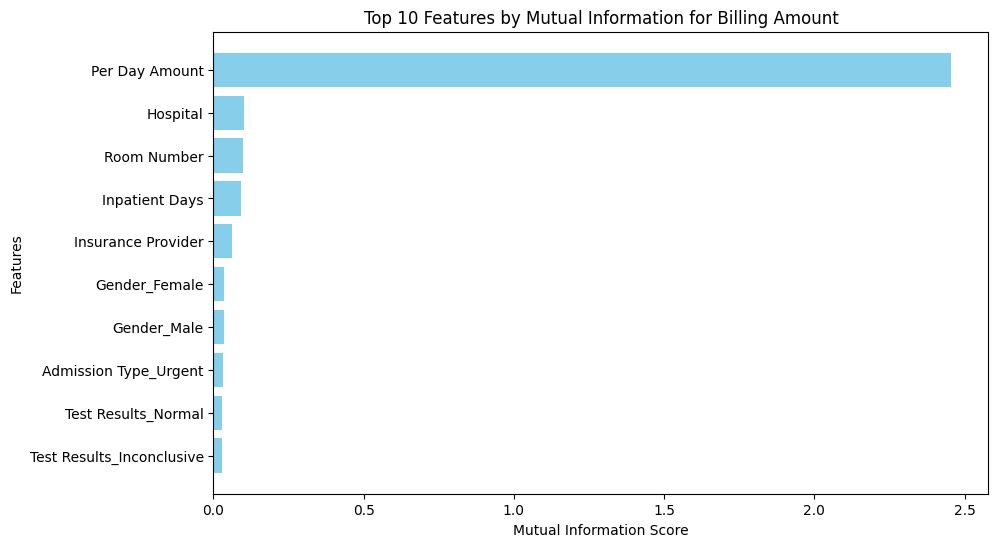

In [175]:
# Bar chart of the top 20 features by mutual information
plt.figure(figsize=(10, 6))
plt.barh(mutual_info_df_sorted['Feature'][:10], mutual_info_df_sorted['Billing Amount'][:10], color='skyblue')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.title('Top 10 Features by Mutual Information for Billing Amount')
plt.gca().invert_yaxis()
plt.show()

In [176]:
mutual_info_matrix = np.zeros((len(indep)))

# Calculate mutual information for each independent-dependent variable pair
for i, var1 in enumerate(indep):
    X = df[[var1]]
    y = df['Log Per Day Amount']
    mutual_info = mutual_info_regression(X, y)
    mutual_info_matrix[i] = mutual_info[0]  

# Convert the matrix to a DataFrame for easier viewing
mutual_info_df = pd.DataFrame(mutual_info_matrix, index=indep, columns=['Log Per Day Amount'])

# Sort by 'Billing Amount' in descending order
mutual_info_df_sorted = mutual_info_df.sort_values(by='Log Per Day Amount', ascending=False).reset_index().head(32)

# Display the top 32 rows
mutual_info_df_sorted = mutual_info_df_sorted.rename(columns={'index': 'Feature'})

In [179]:
print(mutual_info_df_sorted)

                           Feature  Log Per Day Amount
0                   Per Day Amount            8.567444
1                   Inpatient Days            0.712415
2                         Hospital            0.102149
3                      Room Number            0.100765
4               Insurance Provider            0.061740
5                    Gender_Female            0.036009
6                      Gender_Male            0.036002
7          Admission Type_Elective            0.033259
8         Admission Type_Emergency            0.032741
9            Test Results_Abnormal            0.029422
10           Admission Type_Urgent            0.028611
11             Test Results_Normal            0.028611
12       Test Results_Inconclusive            0.027357
13  Medical Condition_Hypertension            0.023065
14           Medication_Penicillin            0.022755
15              Medication_Aspirin            0.022473
16          Medication_Paracetamol            0.022150
17        

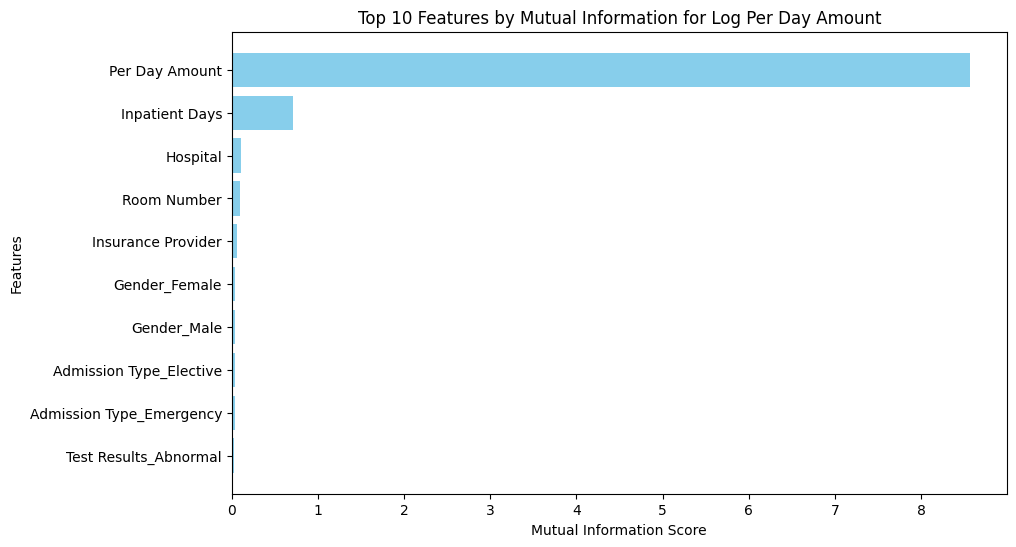

In [177]:
# Bar chart of the top 20 features by mutual information
plt.figure(figsize=(10, 6))
plt.barh(mutual_info_df_sorted['Feature'][:10], mutual_info_df_sorted['Log Per Day Amount'][:10], color='skyblue')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.title('Top 10 Features by Mutual Information for Log Per Day Amount')
plt.gca().invert_yaxis()
plt.show()

Chi-squared test

In [184]:
# Select categorical columns to test
categorical_columns = ['Medical Condition', 'Hospital', 'Gender', 'Blood Type', 'Admission Type', 'Medication', 'Test Results', 'Insurance Provider']

# Target variable
target = 'Billing Amount'

# Initialize a dictionary to store chi-square results
chi2_results = {}

for col in categorical_columns:
    # Create a contingency table
    contingency_table = pd.crosstab(health_df[col], health_df[target].apply(lambda x: 'High' if x > health_df[target].median() else 'Low'))

    # Run chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Store the results
    chi2_results[col] = {'chi2_stat': chi2, 'p_value': p}

# Convert to a DataFrame for better readability
chi2_df = pd.DataFrame.from_dict(chi2_results, orient='index')
print(chi2_df)

                       chi2_stat       p_value
Medical Condition      13.859433  1.652740e-02
Hospital            44618.248099  3.770287e-59
Gender                  1.199352  2.734512e-01
Blood Type              9.789184  2.008383e-01
Admission Type          1.026659  5.984996e-01
Medication              4.324905  3.638169e-01
Test Results            1.840273  3.984647e-01
Insurance Provider      3.044129  5.504679e-01


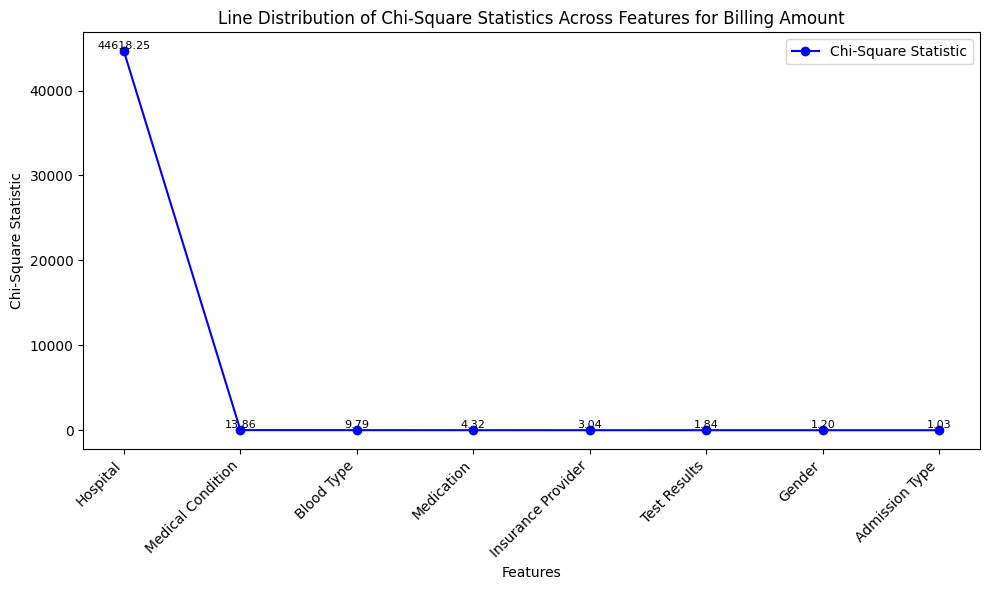

In [185]:
plt.figure(figsize=(10, 6))

# Sort by chi-square statistic for better visualization
chi2_df_sorted = chi2_df.sort_values(by='chi2_stat', ascending=False)

# Line plot for chi-square statistics
plt.plot(chi2_df_sorted.index, chi2_df_sorted['chi2_stat'], marker='o', linestyle='-', color='blue', label='Chi-Square Statistic')
plt.xlabel('Features')
plt.ylabel('Chi-Square Statistic')
plt.title('Line Distribution of Chi-Square Statistics Across Features for Billing Amount')
plt.xticks(rotation=45, ha='right')
plt.legend()

# Annotate p-values
for i, (chi2, p) in enumerate(zip(chi2_df_sorted['chi2_stat'], chi2_df_sorted['p_value'])):
    plt.text(i, chi2, f'{chi2:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [180]:
# Select categorical columns to test
categorical_columns = ['Medical Condition', 'Hospital', 'Gender', 'Blood Type', 'Admission Type', 'Medication', 'Test Results', 'Insurance Provider']

# Target variable
target = 'Log Per Day Amount'

# Initialize a dictionary to store chi-square results
chi2_results = {}

for col in categorical_columns:
    # Create a contingency table
    contingency_table = pd.crosstab(health_df[col], health_df[target].apply(lambda x: 'High' if x > health_df[target].median() else 'Low'))

    # Run chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Store the results
    chi2_results[col] = {'chi2_stat': chi2, 'p_value': p}

# Convert to a DataFrame for better readability
chi2_df = pd.DataFrame.from_dict(chi2_results, orient='index')
print(chi2_df)

                       chi2_stat       p_value
Medical Condition       7.218017  2.049245e-01
Hospital            44329.940064  1.194680e-52
Gender                  0.304068  5.813430e-01
Blood Type              6.446444  4.886906e-01
Admission Type          4.159462  1.249638e-01
Medication              0.998045  9.100924e-01
Test Results            4.713265  9.473872e-02
Insurance Provider      4.978812  2.894784e-01


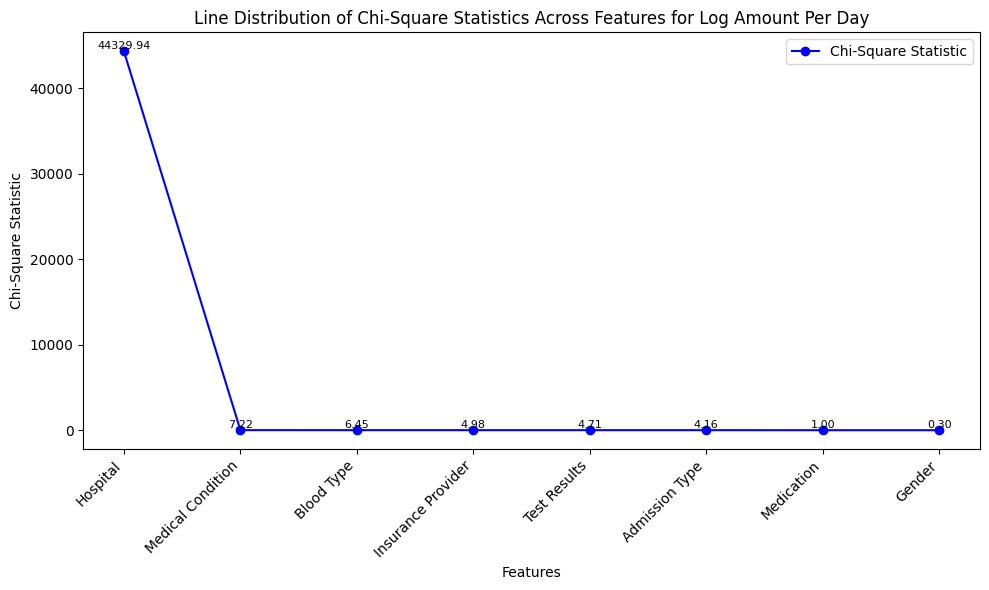

In [182]:
plt.figure(figsize=(10, 6))

# Sort by chi-square statistic for better visualization
chi2_df_sorted = chi2_df.sort_values(by='chi2_stat', ascending=False)

# Line plot for chi-square statistics
plt.plot(chi2_df_sorted.index, chi2_df_sorted['chi2_stat'], marker='o', linestyle='-', color='blue', label='Chi-Square Statistic')
plt.xlabel('Features')
plt.ylabel('Chi-Square Statistic')
plt.title('Line Distribution of Chi-Square Statistics Across Features for Log Amount Per Day')
plt.xticks(rotation=45, ha='right')
plt.legend()

# Annotate p-values
for i, (chi2, p) in enumerate(zip(chi2_df_sorted['chi2_stat'], chi2_df_sorted['p_value'])):
    plt.text(i, chi2, f'{chi2:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

KNN

In [126]:
X = df.drop('Billing Amount', axis=1)
y = df['Billing Amount']

selector = SelectKBest(f_regression, k=5)
X_new = selector.fit_transform(X, y)

print(X_new)

[[ 1.04258072  0.          0.          1.          0.        ]
 [ 0.38249803  0.          0.          0.          1.        ]
 [-0.26421838  0.          0.          0.          1.        ]
 ...
 [-0.41576198  0.          0.          0.          0.        ]
 [ 0.34817062  0.          1.          0.          0.        ]
 [-0.56051894  1.          0.          0.          0.        ]]


In [127]:
model = KNeighborsRegressor(n_neighbors=3)
model.fit(X, y)
print()

In [128]:
y = df['Billing Amount']
a = df.drop(columns = ['Billing Amount'])

In [129]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Create a linear regression model
model = LinearRegression()

rfe = RFE(model, n_features_to_select=5)
rfe.fit_transform(a, y)

print(a.columns[rfe.get_support()])

feature_ranking = rfe.ranking_
selected_features = a.columns[rfe.get_support()]

# Combine the rankings with feature names
rfe_results = pd.DataFrame({
    'Feature': a.columns,
    'Ranking': feature_ranking
}).sort_values(by='Ranking')

# Print the top 20 selected features with their ranking
selected_features_df = rfe_results[rfe_results['Ranking'] == 1]

selected_features_df

Index(['Medical Condition_Diabetes', 'Medical Condition_Obesity',
       'Test Results_Abnormal', 'Test Results_Inconclusive',
       'Test Results_Normal'],
      dtype='object')


,Feature,Ranking
32,Test Results_Normal,1
30,Test Results_Abnormal,1
21,Medical Condition_Obesity,1
19,Medical Condition_Diabetes,1
31,Test Results_Inconclusive,1


In [130]:
from sklearn.metrics import r2_score, root_mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(a, y, test_size=0.2)
model.fit(X_train, y_train)
ypred = model.predict(X_test)
print(r2_score(y_test, ypred))
print(1 - (root_mean_squared_error(y_test, ypred) / y_test.mean()))

0.13858926233580504
0.4855756799238281


In [131]:
b = a[['Gender_Female', 'Gender_Male', 'Blood Type_O+',
       'Medical Condition_Arthritis', 'Medical Condition_Asthma',
       'Medical Condition_Cancer', 'Medical Condition_Diabetes',
       'Medical Condition_Hypertension', 'Medical Condition_Obesity',
       'Admission Type_Elective', 'Admission Type_Emergency',
       'Admission Type_Urgent', 'Medication_Aspirin', 'Medication_Ibuprofen',
       'Medication_Lipitor', 'Medication_Paracetamol', 'Medication_Penicillin',
       'Test Results_Abnormal', 'Test Results_Inconclusive',
       'Test Results_Normal']]

In [132]:
X_train, X_test, y_train, y_test = train_test_split(b, y, test_size=0.2)
model.fit(X_train, y_train)
ypred = model.predict(X_test)
print(r2_score(y_test, ypred))
print(1 - (root_mean_squared_error(y_test, ypred) / y_test.mean()))

-0.000438442376431869
0.4461188332447068


In [133]:
# Create a Lasso regression model
model = Lasso(alpha=0.1)
model.fit(a, y)

# Get feature importance scores
importance = np.abs(model.coef_)
importance_df = pd.DataFrame({'Feature': a.columns, 'Importance': importance})

# Sort the DataFrame by importance scores
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
5,Per Day Amount,6.407823e+03
4,Inpatient Days,3.376796e+03
18,Medical Condition_Cancer,3.057546e+02
12,Blood Type_B+,2.204296e+02
14,Blood Type_O+,2.083122e+02
15,Blood Type_O-,1.886276e+02
21,Medical Condition_Obesity,1.826689e+02
29,Medication_Penicillin,1.580594e+02
11,Blood Type_AB-,1.550284e+02
10,Blood Type_AB+,1.416301e+02


In [82]:
X_train, X_test, y_train, y_test = train_test_split(a, y, test_size=0.2)
model.fit(X_train, y_train)
ypred = model.predict(X_test)
print(r2_score(y_test, ypred))
print(1 - (root_mean_squared_error(y_test, ypred) / y_test.mean()))


0.14126401542383926
0.4897183749162456


In [83]:
b = a[['Medical Condition_Arthritis', 'Blood Type_O+', 'Hospital',
       'Age', 'Blood Type_B+',
       'Medical Condition_Diabetes', 'Inpatient Days']]

In [84]:
X_train, X_test, y_train, y_test = train_test_split(b, y, test_size=0.2)
model.fit(X_train, y_train)
ypred = model.predict(X_test)
print(r2_score(y_test, ypred))
print(1 - (root_mean_squared_error(y_test, ypred) / y_test.mean()))
# Feature Medical Condition_Arthritis with importance: 1730.5128
# Feature Blood Type_O+ with importance: 1714.5136
# Feature Hospital with importance: 1683.9190
# Feature Age with importance: 1682.5838
# Feature Blood Type_B+ with importance: 1647.4970
# Feature Medical Condition_Diabetes with importance: 1636.3089
# Feature Inpatient Days with importance: 1620.2044
# Feature Blood Type_O- with importance: 1578.7868
# Feature Blood Type_AB- with importance: 1560.9029
# Feature Blood Type_A- with importance: 1513.1654
# Feature Medical Condition_Cancer with importance: 1510.8546
# Feature Gender with importance: 1508.0452
# Feature Per Day Amount with importance: 1487.7135
# Feature Blood Type_B- with importance: 1487.0563
# Feature Room Number with importance: 1476.8901

-6.039231791188371e-05
0.4464212927355843


In [85]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(b, df['Billing Amount'], test_size=0.2, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#activation{‘identity’, ‘logistic’, ‘tanh’, ‘relu’}
#solver{‘lbfgs’, ‘sgd’, ‘adam’}
clf = MLPRegressor(hidden_layer_sizes=(400,), max_iter=1000, alpha = 0.005, learning_rate_init= 0.002, activation='relu', solver='adam', random_state=2)
clf.fit(X_train, y_train)

feature_importance = np.abs(clf.coefs_[0]).sum(axis=1)
sorted_indices = np.argsort(feature_importance)[::-1]
for idx in sorted_indices[:15]:
    print(f"Feature {a.columns[idx]} with importance: {feature_importance[idx]:.4f}")
ypred = clf.predict(X_test)
print(1 - (root_mean_squared_error(y_test, ypred) / y_test.mean()))

Feature Age with importance: 2278.2685
Feature Per Day Amount with importance: 2084.3400
Feature Inpatient Days with importance: 2030.3486
Feature Hospital with importance: 1930.2020
Feature Room Number with importance: 1174.2023
Feature Gender_Female with importance: 1132.7449
Feature Insurance Provider with importance: 1027.8828
0.4423929430803608


In [86]:
b = a[['Per Day Amount', 'Inpatient Days', 'Test Results_Abnormal']]

X_train, X_test, y_train, y_test = train_test_split(b, df['Billing Amount'], test_size=0.2, random_state=42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#activation{‘identity’, ‘logistic’, ‘tanh’, ‘relu’}
#solver{‘lbfgs’, ‘sgd’, ‘adam’}

clf = MLPRegressor(hidden_layer_sizes=(400,), max_iter=1000, alpha = 0.005, learning_rate_init= 0.002, activation='relu', solver='adam', random_state=2)
clf.fit(X_train, y_train)

ypred = clf.predict(X_test)
print(r2_score(y_test, ypred))
print(1 - (root_mean_squared_error(y_test, ypred) / y_test.mean()))

0.989265615643001
0.9422697843616032


/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [87]:
df['Billing Amount']

bins = [0, 10000, 20000, 30000, 40000, float('inf')]
labels = [10, 20, 30, 40, 50]

df['cat bill'] = pd.cut(df['Billing Amount'], bins=bins, labels=labels, right=True)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
df['l'] = kmeans.fit_predict(df[['Billing Amount']])

centroids = kmeans.cluster_centers_

# Find the min and max values within each cluster
cluster_edges = {}
for cluster_label in df['l'].unique():
    # Filter the data for the current cluster
    cluster_data = df[df['l'] == cluster_label]['Billing Amount']
    
    # Find the min and max values for each cluster (edges)
    min_val = cluster_data.min()
    max_val = cluster_data.max()
    
    cluster_edges[cluster_label] = (min_val, max_val)

# Print the cluster edges
print("Cluster edges (min, max) for each cluster:")
for cluster_label, (min_val, max_val) in cluster_edges.items():
    print(f"Cluster {cluster_label}: Min = {min_val}, Max = {max_val}")
print(df['cat bill'])

Cluster edges (min, max) for each cluster:
Cluster 0: Min = 10363.66893067308, Max = 19878.29987681973
Cluster 4: Min = 29703.870474486597, Max = 39836.3848779898
Cluster 2: Min = 19879.862382196294, Max = 29699.31359663662
Cluster 1: Min = 39837.74085278687, Max = 52764.276736469175
Cluster 3: Min = 9.238787497393332, Max = 10362.621045769216
0        20
1        40
2        30
3        40
4        20
         ..
55495    10
55496    40
55497    30
55498    40
55499    10
Name: cat bill, Length: 55392, dtype: category
Categories (5, int64): [10 < 20 < 30 < 40 < 50]


In [88]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
b = a[['Inpatient Days', 'Per Day Amount', 'Room Number']]
X_train, X_test, y_train, y_test = train_test_split(a, df['cat bill'], test_size=0.2, random_state=42)

#print(X_train)
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.fit_transform(X_test)

#activation{‘identity’, ‘logistic’, ‘tanh’, ‘relu’}
#solver{‘lbfgs’, ‘sgd’, ‘adam’}

clf = MLPClassifier(hidden_layer_sizes=(400,), max_iter=1000, alpha = 0.1, learning_rate_init= 0.005, activation='relu', solver='adam', random_state=2)
clf.fit(X_train, y_train)

feature_importance = np.abs(clf.coefs_[0]).sum(axis=1)
sorted_indices = np.argsort(feature_importance)[::-1]
for idx in sorted_indices[:15]:
    print(f"Feature {a.columns[idx]} with importance: {feature_importance[idx]:.4f}")
ypred = clf.predict(X_test)
print(accuracy_score(y_test, ypred))
#print(1 - (root_mean_squared_error(y_test, ypred) / y_test.mean()))

Feature Per Day Amount with importance: 8.3205
Feature Hospital with importance: 7.6160
Feature Insurance Provider with importance: 2.5452
Feature Inpatient Days with importance: 1.8778
Feature Gender_Male with importance: 0.6445
Feature Age with importance: 0.6221
Feature Room Number with importance: 0.4898
Feature Admission Type_Urgent with importance: 0.4871
Feature Test Results_Abnormal with importance: 0.4701
Feature Medication_Ibuprofen with importance: 0.4672
Feature Blood Type_A- with importance: 0.4598
Feature Medical Condition_Arthritis with importance: 0.4461
Feature Gender_Female with importance: 0.4039
Feature Admission Type_Emergency with importance: 0.3730
Feature Test Results_Inconclusive with importance: 0.3663
0.20110118241718566


In [89]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
b = a[['Inpatient Days', 'Per Day Amount', 'Test Results_Abnormal', 'Hospital']]
X_train, X_test, y_train, y_test = train_test_split(b, df['cat bill'], test_size=0.2, random_state=42)

#print(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#activation{‘identity’, ‘logistic’, ‘tanh’, ‘relu’}
#solver{‘lbfgs’, ‘sgd’, ‘adam’}

clf = MLPClassifier(hidden_layer_sizes=(400,), max_iter=1000, alpha = 0.005, learning_rate_init= 0.002, activation='relu', solver='adam', random_state=12)
clf.fit(X_train, y_train)

ypred = clf.predict(X_test)
print(accuracy_score(y_test, ypred))

0.980684177272317


In [90]:
from sklearn.inspection import permutation_importance

# Assuming clf is your trained MLPRegressor and X_test, y_test are your test data
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)

# Get mean importance scores for each feature
importance_scores = result.importances_mean

# Pair feature names with their importance scores
feature_importances = list(zip(X_test.columns, importance_scores))

# Sort features by importance
feature_importances.sort(key=lambda x: x[1], reverse=True)

# Display the most important features
print("Feature importances:")
for feature, importance in feature_importances:
    print(f"{feature}: {importance:.4f}")

AttributeError: 'numpy.ndarray' object has no attribute 'columns'